In [1]:
import os
import sys

sys.path.append("../../../")

import json
import pickle

import fasttreeshap
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import RepeatedKFold, cross_val_score
from povertymapping import settings
%reload_ext autoreload
%autoreload 2

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Load Training Data

In [2]:
COUNTRY_CODE = "tl"

In [14]:
DATA_DIR = settings.DATA_DIR.resolve()
ROLLOUT_DIR = DATA_DIR/f"rollout/{COUNTRY_CODE}"

In [2]:
ROLLOUT_DATE = "-".join(os.getcwd().split("/")[-2].split("-")[:3])

# CSV file contains all data
# Metadata JSON file lists the feature columns and label column
data = pd.read_csv(f"{ROLLOUT_DIR}/{ROLLOUT_DATE}-training-data.csv")
with open(f"{ROLLOUT_DIR}/{ROLLOUT_DATE}-training-data-columns.json", "r") as file:
    column_metadata = json.load(file)

features = data[column_metadata["features"]]
labels = data[column_metadata["label"]]

# Cross-Validation

In [3]:
# Set parameters
CV_K_FOLDS = 5
CV_NUM_REPEATS = 5
RANDOM_SEED = 42

In [4]:
print(f"Performing {CV_K_FOLDS}-fold CV...")
cv = RepeatedKFold(
    n_splits=CV_K_FOLDS,
    n_repeats=CV_NUM_REPEATS,
    random_state=RANDOM_SEED,
)

print(cv.split(features))

Performing 5-fold CV...
<generator object _RepeatedSplits.split at 0x7f25654ffdd0>


In [5]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED, verbose=0)

R_cv = cross_val_score(model, features.values, labels.values.ravel(), cv=cv)
cv_mean = round(np.array(R_cv).mean(), 2)
cv_std = round(np.array(R_cv).std(), 2)

print("Cross validation scores are: ", R_cv)
print(f"Cross validation R^2 mean: {cv_mean}")
print(f"Cross validation R^2 std: {cv_std}")

Cross validation scores are:  [0.52705369 0.7191233  0.62597134 0.62725306 0.60707198 0.59573009
 0.64103504 0.56416994 0.65353403 0.58714065 0.64706741 0.57839162
 0.68844804 0.56323569 0.39276071 0.57982091 0.73729883 0.55294025
 0.62533875 0.55345153 0.58199904 0.51790932 0.66315305 0.56605196
 0.62420234]
Cross validation R^2 mean: 0.6
Cross validation R^2 std: 0.07


# Train the final model

For training the final model, we train on all the available data.

In [6]:
model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED, verbose=0)
model.fit(features.values, labels.values.ravel())

RandomForestRegressor(random_state=42)

In [7]:
model_save_path = f"{ROLLOUT_DIR}/{ROLLOUT_DATE}-{COUNTRY_CODE}-single-country-model.pkl"
with open(model_save_path, "wb") as file:
    pickle.dump(model, file)

# SHAP

In [8]:
explainer = fasttreeshap.TreeExplainer(model, algorithm="auto", n_jobs=-1)
shap_values = explainer(features).values

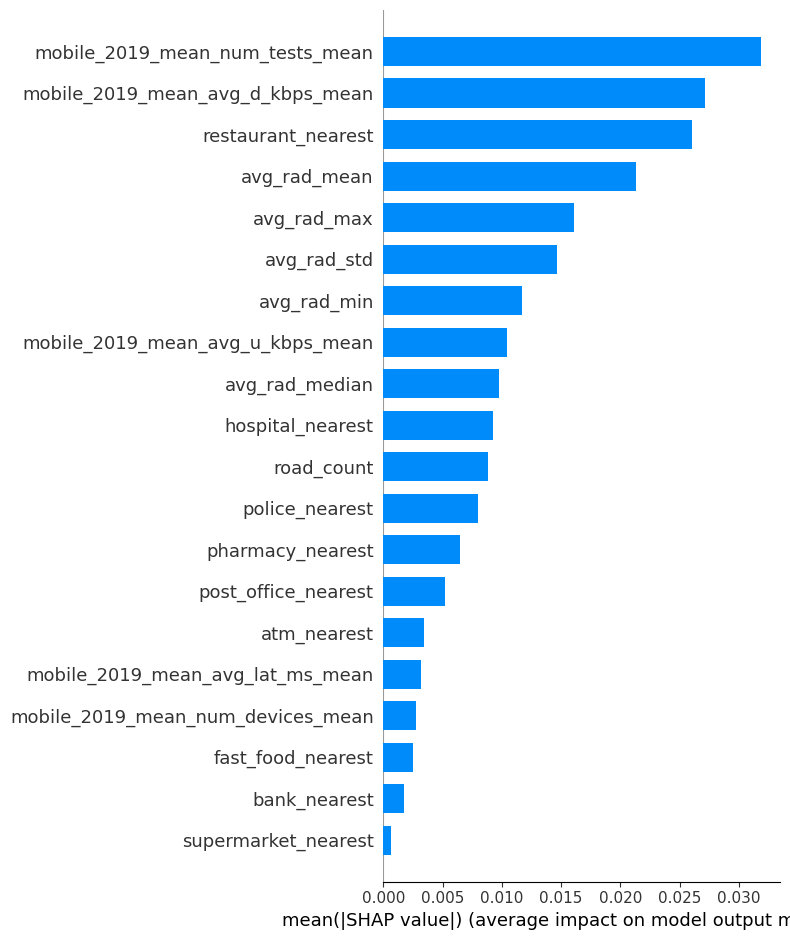

In [9]:
shap.summary_plot(
    shap_values, features, feature_names=features.columns, plot_type="bar"
)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


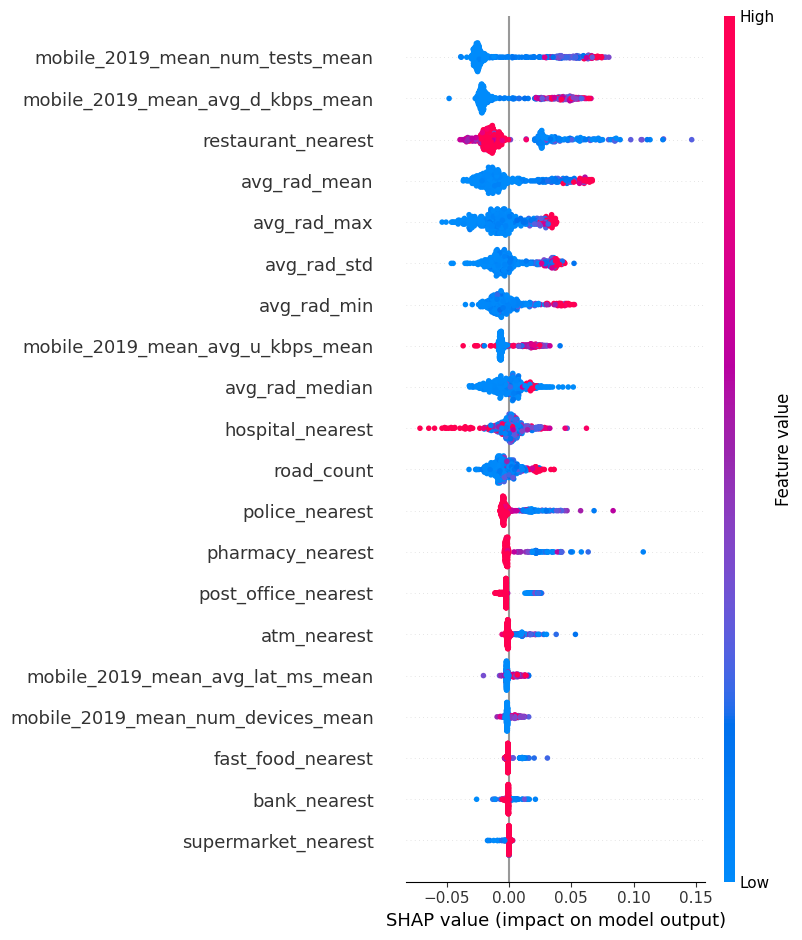

In [10]:
shap.summary_plot(shap_values, features.values, feature_names=features.columns)